LOADING DEPENDENCIES

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import (
    train_test_split,
    cross_val_score, 
    GridSearchCV)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    LogisticRegressionCV,
    Lasso,
    Ridge,
    ElasticNet
)
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
    make_scorer,
    accuracy_score, 
    classification_report
)
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import (
    KFold,
    ShuffleSplit,
    cross_val_score,
    cross_validate,
    RandomizedSearchCV,
    GridSearchCV
)
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from imblearn.over_sampling import SMOTE
from collections import Counter
from tqdm import tqdm
import scipy.stats as sc
from scipy.stats import uniform
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df=pd.read_csv("airline_passenger_satisfaction.csv")

In [3]:
df.head()

,ID,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,...,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
0,1,Male,48,First-time,Business,Business,821,2,5.0,3,...,3,5,2,5,5,5,3,5,5,Neutral or Dissatisfied
1,2,Female,35,Returning,Business,Business,821,26,39.0,2,...,5,4,5,5,3,5,2,5,5,Satisfied
2,3,Male,41,Returning,Business,Business,853,0,0.0,4,...,3,5,3,5,5,3,4,3,3,Satisfied
3,4,Male,50,Returning,Business,Business,1905,0,0.0,2,...,5,5,5,4,4,5,2,5,5,Satisfied
4,5,Female,49,Returning,Business,Business,3470,0,1.0,3,...,3,4,4,5,4,3,3,3,3,Satisfied


In [4]:
df.shape #129880 entries

(129880, 24)

In [5]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 24 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   ID                                      129880 non-null  int64  
 1   Gender                                  129880 non-null  object 
 2   Age                                     129880 non-null  int64  
 3   Customer Type                           129880 non-null  object 
 4   Type of Travel                          129880 non-null  object 
 5   Class                                   129880 non-null  object 
 6   Flight Distance                         129880 non-null  int64  
 7   Departure Delay                         129880 non-null  int64  
 8   Arrival Delay                           129487 non-null  float64
 9   Departure and Arrival Time Convenience  129880 non-null  int64  
 10  Ease of Online Booking                  1298

In [6]:
df.isna().sum() #There are some NA's for 'Arrival Delay'

ID                                          0
Gender                                      0
Age                                         0
Customer Type                               0
Type of Travel                              0
Class                                       0
Flight Distance                             0
Departure Delay                             0
Arrival Delay                             393
Departure and Arrival Time Convenience      0
Ease of Online Booking                      0
Check-in Service                            0
Online Boarding                             0
Gate Location                               0
On-board Service                            0
Seat Comfort                                0
Leg Room Service                            0
Cleanliness                                 0
Food and Drink                              0
In-flight Service                           0
In-flight Wifi Service                      0
In-flight Entertainment           

In [7]:
#Initial global transformation of data (creation of boolean/categorical variables)

df = df.drop(columns=["ID"])
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0}) # Gender: Male=1, Female=0
df['Customer Type'] = df['Customer Type'].map({'First-time': 0, 'Returning': 1}) # Customer type: Returning=1, First-time=0
df['Type of Travel'] = df['Type of Travel'].map({'Business': 1, 'Personal': 0}) # Type of travel: Business=1, Personal=0
df['Class'] = df['Class'].map({'Economy': 1,'Economy Plus': 2, 'Business': 3}) #Class: Economic=1, Economic Plus=2, Business=3 
df['Satisfaction'] = df['Satisfaction'].map({'Satisfied': 1, 'Neutral or Dissatisfied': 0}) #Satisfaction: Satisfied=1, Neutral or dissatisfied=0

In [8]:
df.describe() #'Satisfaction' as target variable

,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,...,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
count,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129487.000000,129880.000000,129880.000000,...,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000
mean,0.492616,39.427957,0.816908,0.690584,2.029650,1190.316392,14.713713,15.091129,3.057599,2.756876,...,3.383023,3.441361,3.350878,3.286326,3.204774,3.642193,2.728696,3.358077,3.632114,0.434463
std,0.499947,15.119360,0.386743,0.462255,0.962636,997.452477,38.071126,38.465650,1.526741,1.401740,...,1.287099,1.319289,1.316252,1.313682,1.329933,1.176669,1.329340,1.334049,1.180025,0.495688
min,0.000000,7.000000,0.000000,0.000000,1.000000,31.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,27.000000,1.000000,0.000000,1.000000,414.000000,0.000000,0.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000,2.000000,3.000000,0.000000
50%,0.000000,40.000000,1.000000,1.000000,2.000000,844.000000,0.000000,0.000000,3.000000,3.000000,...,4.000000,4.000000,4.000000,3.000000,3.000000,4.000000,3.000000,4.000000,4.000000,0.000000
75%,1.000000,51.000000,1.000000,1.000000,3.000000,1744.000000,12.000000,13.000000,4.000000,4.000000,...,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,5.000000,1.000000
max,1.000000,85.000000,1.000000,1.000000,3.000000,4983.000000,1592.000000,1584.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000


In [9]:
# Define train and target 
target = df[['Satisfaction']] 
train = df.drop('Satisfaction', axis = 1) 

In [10]:
#Division of dataset
x_train_full, x_test = train_test_split(train, test_size=0.2, random_state=123)
y_train_full, y_test = train_test_split(target, test_size=0.2, random_state=123)

In [11]:
#Also, let's split the dataset in a way it will also include the target variable (it will be useful during model preparation)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=123)

In [12]:
print("\nTRAIN:")
display(x_train_full.head())
print("SHAPE:",x_train_full.shape)

print("\nTEST:")
display(x_test.head())
print("SHAPE:",x_test.shape)


TRAIN:


,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,...,Gate Location,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling
74733,0,7,1,0,1,1464,73,63.0,1,3,...,4,2,4,3,4,4,3,3,4,2
99295,1,45,1,1,3,337,33,17.0,3,4,...,4,4,5,4,4,5,4,4,4,4
75090,1,39,1,1,3,1846,0,0.0,5,5,...,5,5,4,5,5,3,5,5,5,5
107819,0,38,0,1,1,349,23,33.0,3,3,...,3,2,5,4,5,5,3,3,5,3
114012,1,35,1,0,1,1844,29,11.0,4,2,...,4,3,1,2,1,1,5,2,1,3


SHAPE: (103904, 22)

TEST:


,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,...,Gate Location,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling
28551,0,25,1,0,1,2688,20,0.0,4,1,...,3,5,5,5,5,5,4,1,5,4
64771,0,60,1,1,3,469,0,0.0,3,3,...,3,5,5,5,3,3,5,3,5,5
86495,1,68,1,0,1,762,0,0.0,2,2,...,4,4,1,4,2,2,4,2,2,3
113447,1,58,1,1,3,3050,64,62.0,4,4,...,4,2,5,2,3,4,2,4,2,2
123276,0,45,1,0,1,600,0,4.0,2,2,...,2,5,5,2,3,2,5,2,5,5


SHAPE: (25976, 22)


In [13]:
#Let's see whether target variable ('Satisfaction') is balanced
{i: y_train_full.quantile(i) for i in np.arange(0, 1.1, 0.1)} #mild imbalance but rather acceptable (therefore, we don't need to rebalance it with e.g. SMOTE)

{0.0: Satisfaction    0.0
 Name: 0.0, dtype: float64,
 0.1: Satisfaction    0.0
 Name: 0.1, dtype: float64,
 0.2: Satisfaction    0.0
 Name: 0.2, dtype: float64,
 0.30000000000000004: Satisfaction    0.0
 Name: 0.30000000000000004, dtype: float64,
 0.4: Satisfaction    0.0
 Name: 0.4, dtype: float64,
 0.5: Satisfaction    0.0
 Name: 0.5, dtype: float64,
 0.6000000000000001: Satisfaction    1.0
 Name: 0.6000000000000001, dtype: float64,
 0.7000000000000001: Satisfaction    1.0
 Name: 0.7000000000000001, dtype: float64,
 0.8: Satisfaction    1.0
 Name: 0.8, dtype: float64,
 0.9: Satisfaction    1.0
 Name: 0.9, dtype: float64,
 1.0: Satisfaction    1.0
 Name: 1.0, dtype: float64}

In [14]:
{i: y_test.quantile(i) for i in np.arange(0, 1.1, 0.1)} #similar distribution between train and test set

{0.0: Satisfaction    0.0
 Name: 0.0, dtype: float64,
 0.1: Satisfaction    0.0
 Name: 0.1, dtype: float64,
 0.2: Satisfaction    0.0
 Name: 0.2, dtype: float64,
 0.30000000000000004: Satisfaction    0.0
 Name: 0.30000000000000004, dtype: float64,
 0.4: Satisfaction    0.0
 Name: 0.4, dtype: float64,
 0.5: Satisfaction    0.0
 Name: 0.5, dtype: float64,
 0.6000000000000001: Satisfaction    1.0
 Name: 0.6000000000000001, dtype: float64,
 0.7000000000000001: Satisfaction    1.0
 Name: 0.7000000000000001, dtype: float64,
 0.8: Satisfaction    1.0
 Name: 0.8, dtype: float64,
 0.9: Satisfaction    1.0
 Name: 0.9, dtype: float64,
 1.0: Satisfaction    1.0
 Name: 1.0, dtype: float64}

In [15]:
#Filling out the NA's
x_train_full.isna().sum()

Gender                                      0
Age                                         0
Customer Type                               0
Type of Travel                              0
Class                                       0
Flight Distance                             0
Departure Delay                             0
Arrival Delay                             308
Departure and Arrival Time Convenience      0
Ease of Online Booking                      0
Check-in Service                            0
Online Boarding                             0
Gate Location                               0
On-board Service                            0
Seat Comfort                                0
Leg Room Service                            0
Cleanliness                                 0
Food and Drink                              0
In-flight Service                           0
In-flight Wifi Service                      0
In-flight Entertainment                     0
Baggage Handling                  

In [16]:
x_train_full[x_train_full['Arrival Delay'].isnull()]

,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,...,Gate Location,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling
3448,1,34,1,0,1,213,0,NaN,4,2,...,4,5,3,4,3,3,5,2,3,5
3638,1,44,1,1,3,431,6,NaN,5,3,...,5,5,5,5,4,5,5,5,5,5
48386,1,47,1,0,1,587,17,NaN,2,1,...,3,1,4,1,4,4,4,1,4,4
114133,0,33,1,1,3,3546,3,NaN,4,4,...,4,5,4,5,4,5,5,4,5,5
39694,0,63,1,1,3,205,32,NaN,4,4,...,4,5,5,5,5,2,5,4,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97947,1,48,1,1,3,391,0,NaN,1,1,...,1,5,4,5,5,4,5,1,5,5
19505,1,30,1,1,3,2801,60,NaN,4,4,...,4,3,5,1,5,5,2,4,5,4
89344,1,26,1,1,3,1541,1,NaN,4,4,...,4,3,2,4,2,2,3,2,2,4
8522,0,12,1,0,1,737,0,NaN,5,3,...,1,3,3,4,3,3,4,3,3,5


In [17]:
#Total number of missing data is 393- it is few comparing to whole dataset size so we will use the median to fill the data (we assume it is MAR).
x_train_full['Arrival Delay'].fillna(x_train_full['Arrival Delay'].median(), inplace=True)

In [18]:
x_train_full[x_train_full['Arrival Delay'].isnull()]

,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,...,Gate Location,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling


In [19]:
#We apply same transformation to other train set
df_train['Arrival Delay'].fillna(df_train['Arrival Delay'].median(), inplace=True)

In [20]:
# Creation of a validation set from training data
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.2)

INITIAL DATA EXPLORATION

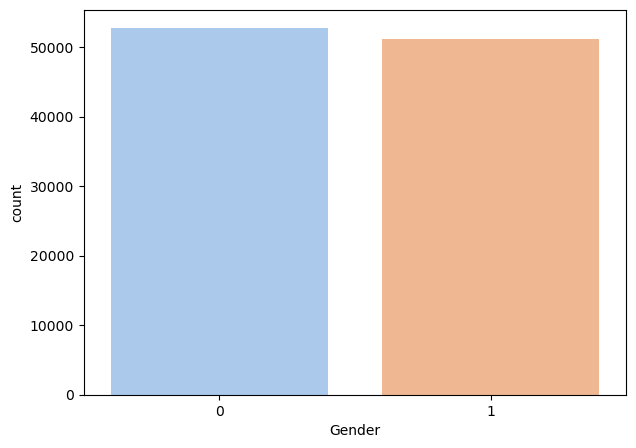

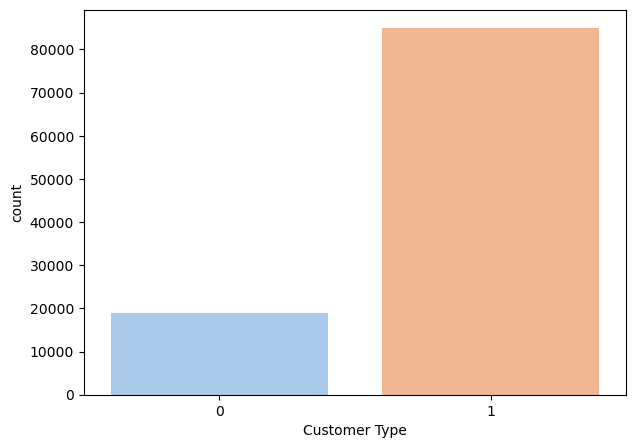

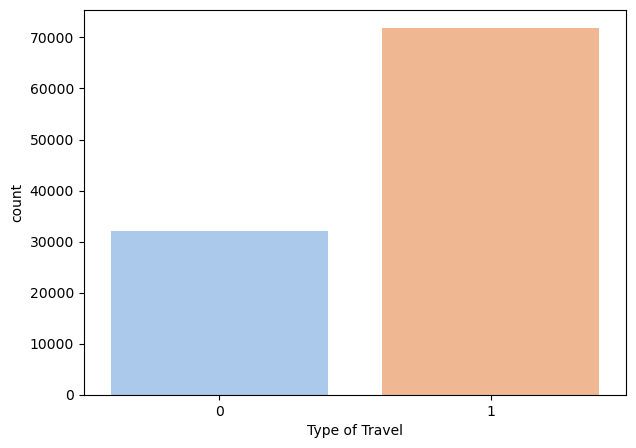

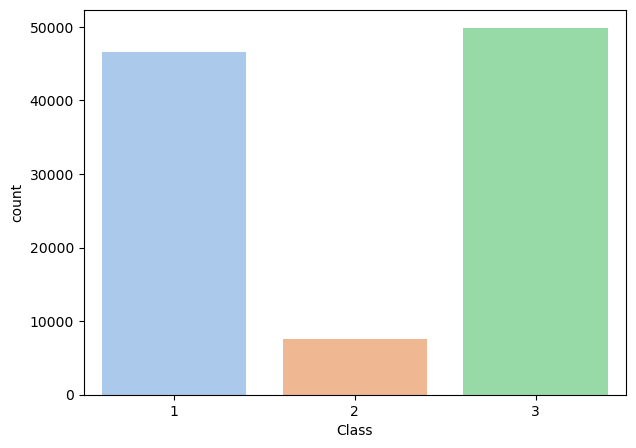

In [21]:
#Exeplary plots for categorical variables
Col= ['Gender', 'Customer Type','Type of Travel','Class']
for col in Col:
    plt.figure(figsize=(7,5))
    sns.countplot(x=col,data=x_train_full, palette="pastel")
    plt.show()

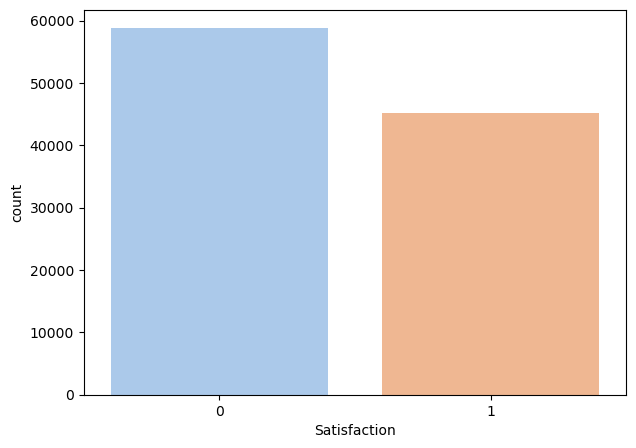

In [22]:
#Distribution of target variable
Col= ['Satisfaction']
for col in Col:
    plt.figure(figsize=(7,5))
    sns.countplot(x=col,data=y_train_full, palette="pastel")
    plt.show() 

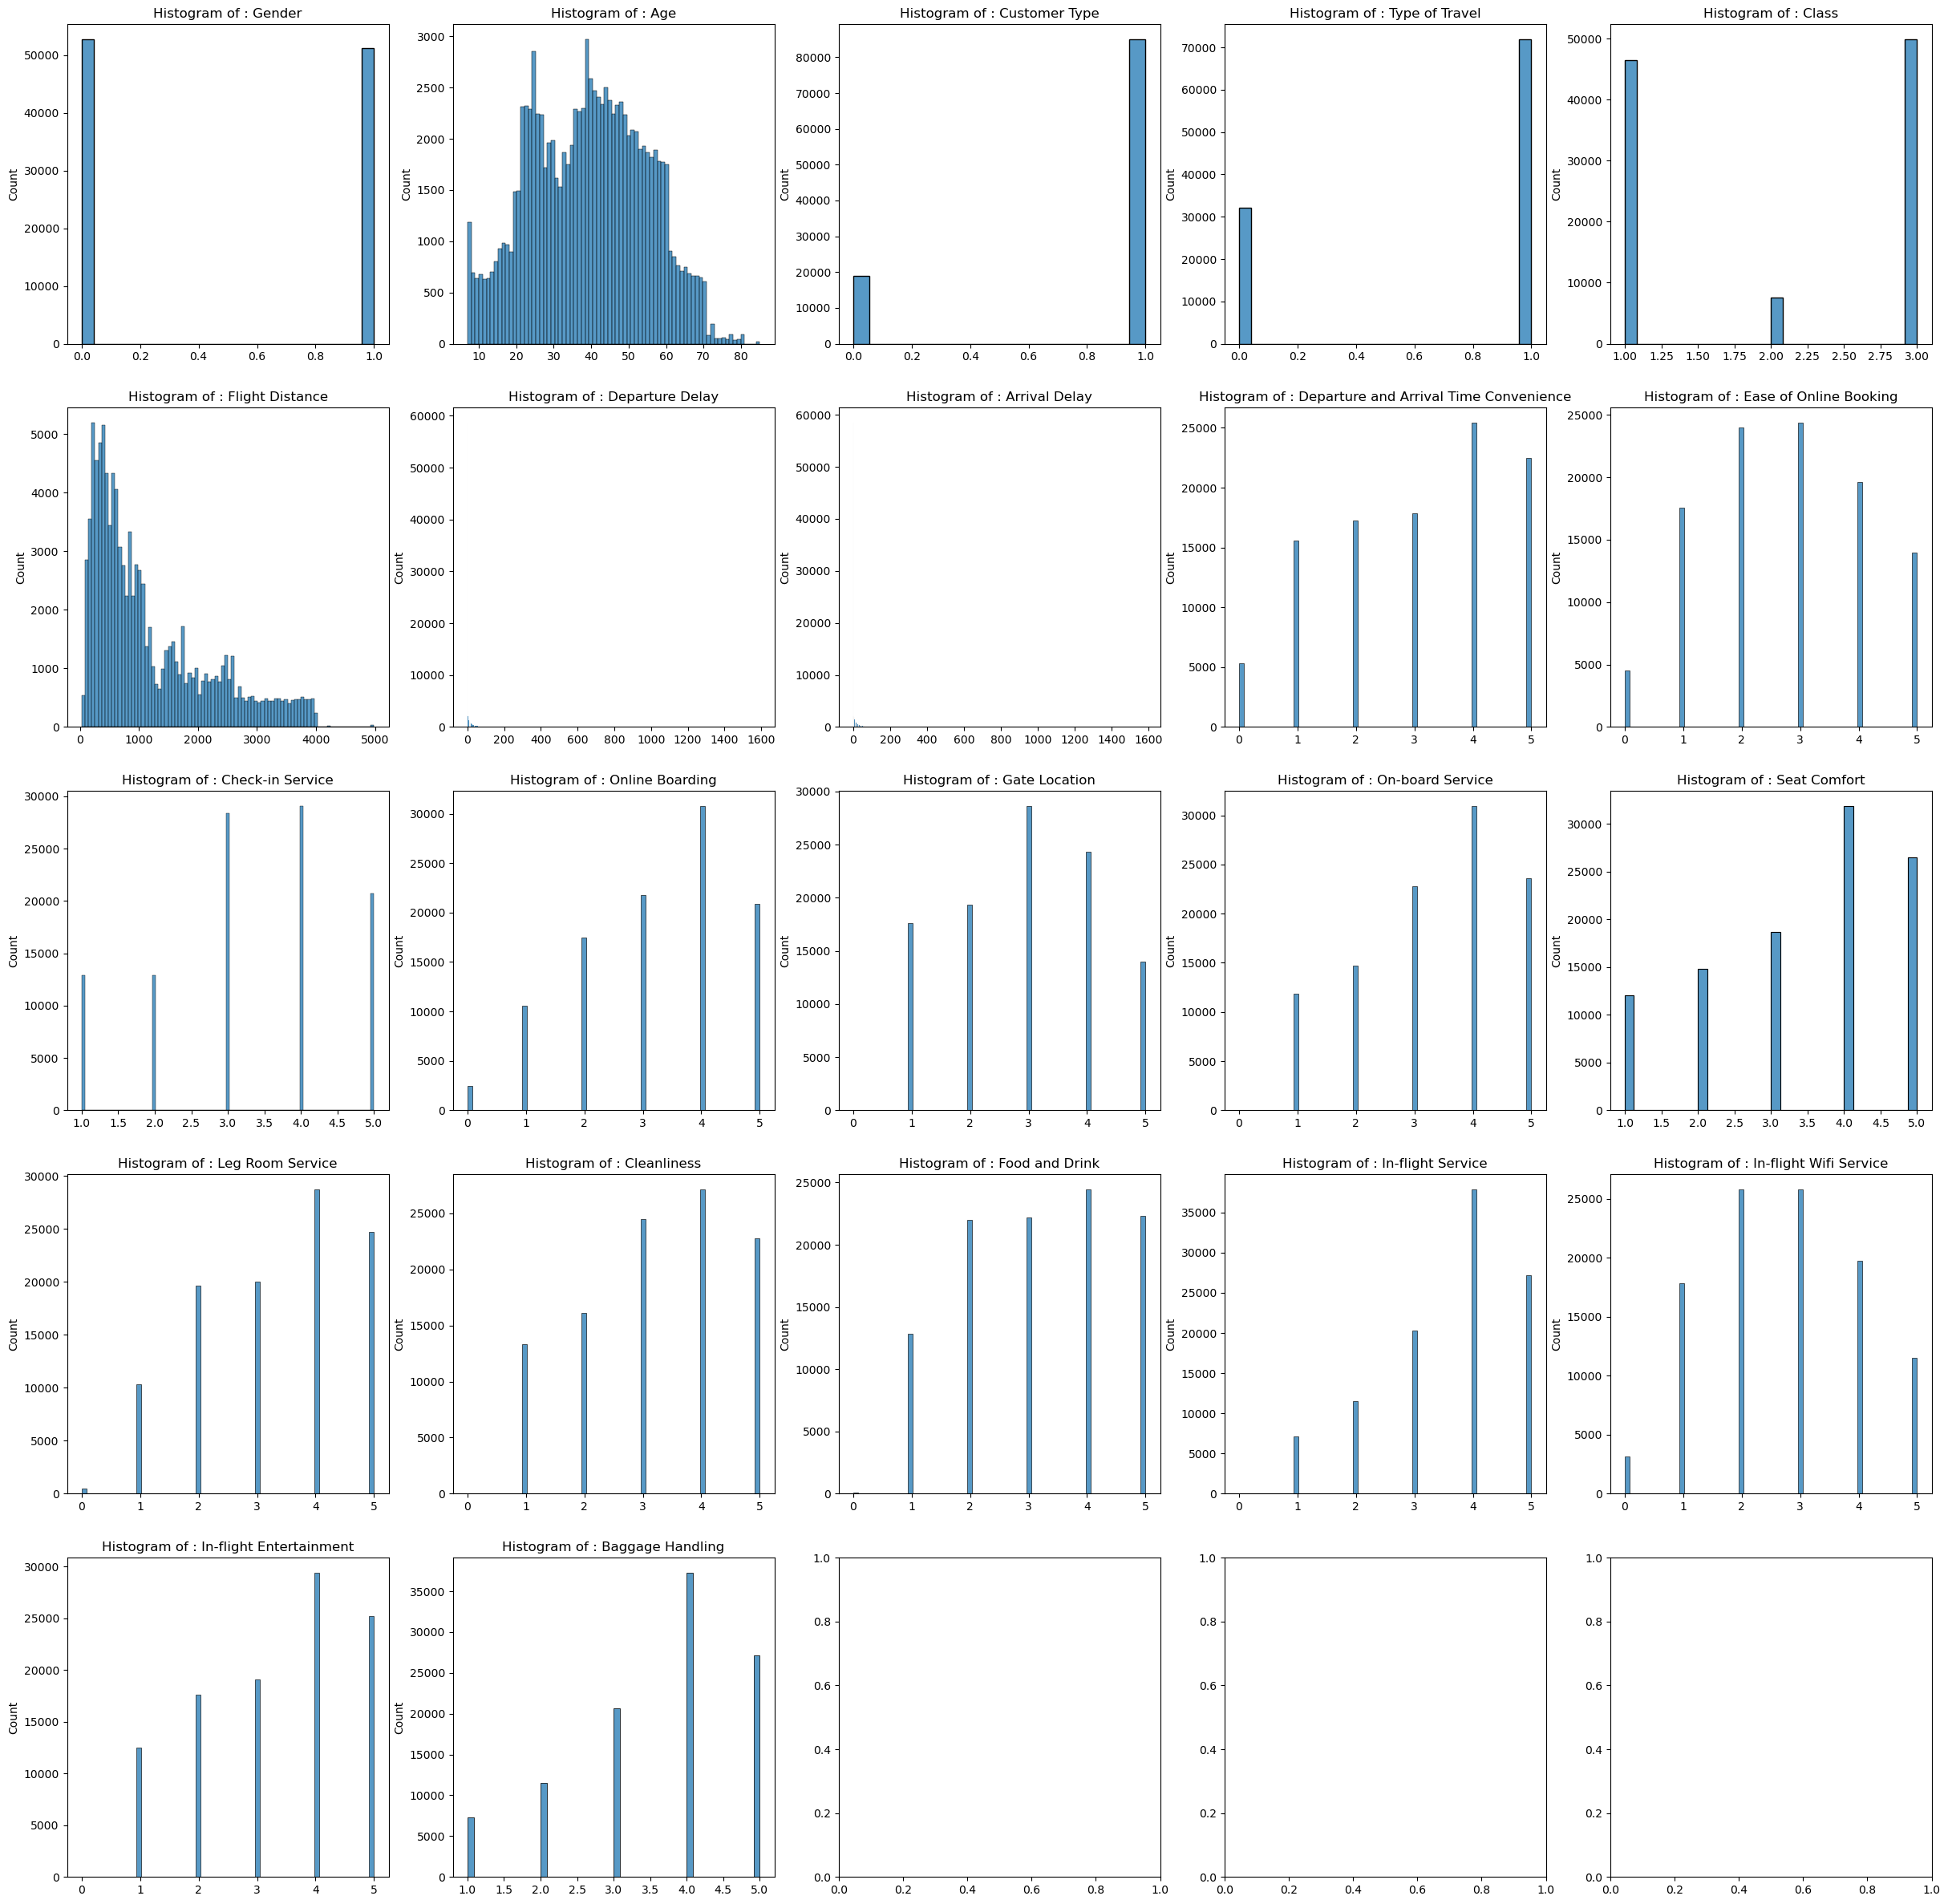

In [23]:
#Histplots of all variables
fig, axes = plt.subplots(ncols=5, nrows=5, figsize=(30, 30))
for i, ax in zip(x_train_full.columns, axes.flat):
    sns.histplot(x=x_train_full[i], ax=ax).set(title=f"Histogram of : {i}", xlabel="")
plt.show() 

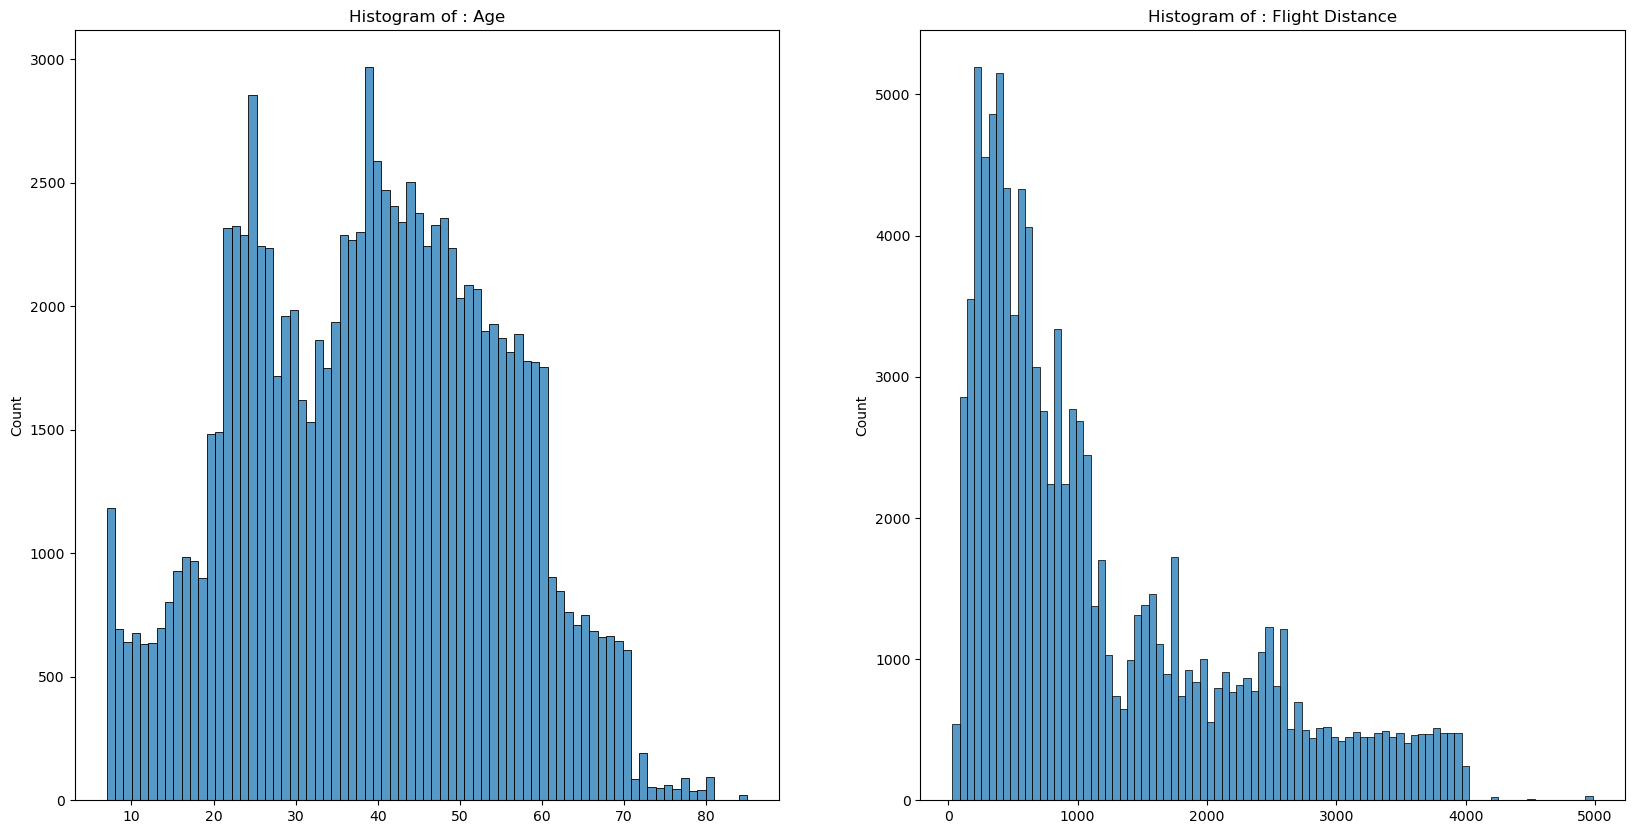

In [24]:
#Histplots for continuous variables
columns= ["Age", "Flight Distance"]
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 10))
for i, ax in zip(columns, axes.flat):
    sns.histplot(x=x_train_full[i], ax=ax).set(title=f"Histogram of : {i}", xlabel="")
plt.show() 

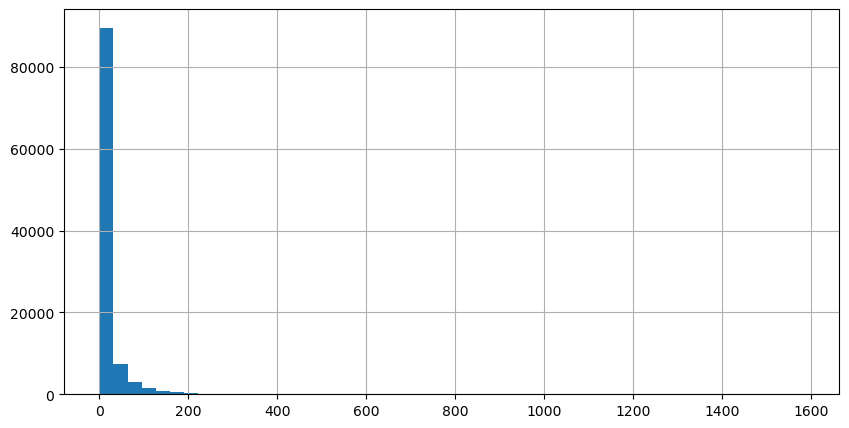

In [25]:
#There is a problem for 'Arrival Delay' histogram- extreme outliers, the variable needs clipping
x_train_full["Arrival Delay"].hist(bins=50, figsize=(10, 5))
plt.show() #same conclusion for Departure Delay

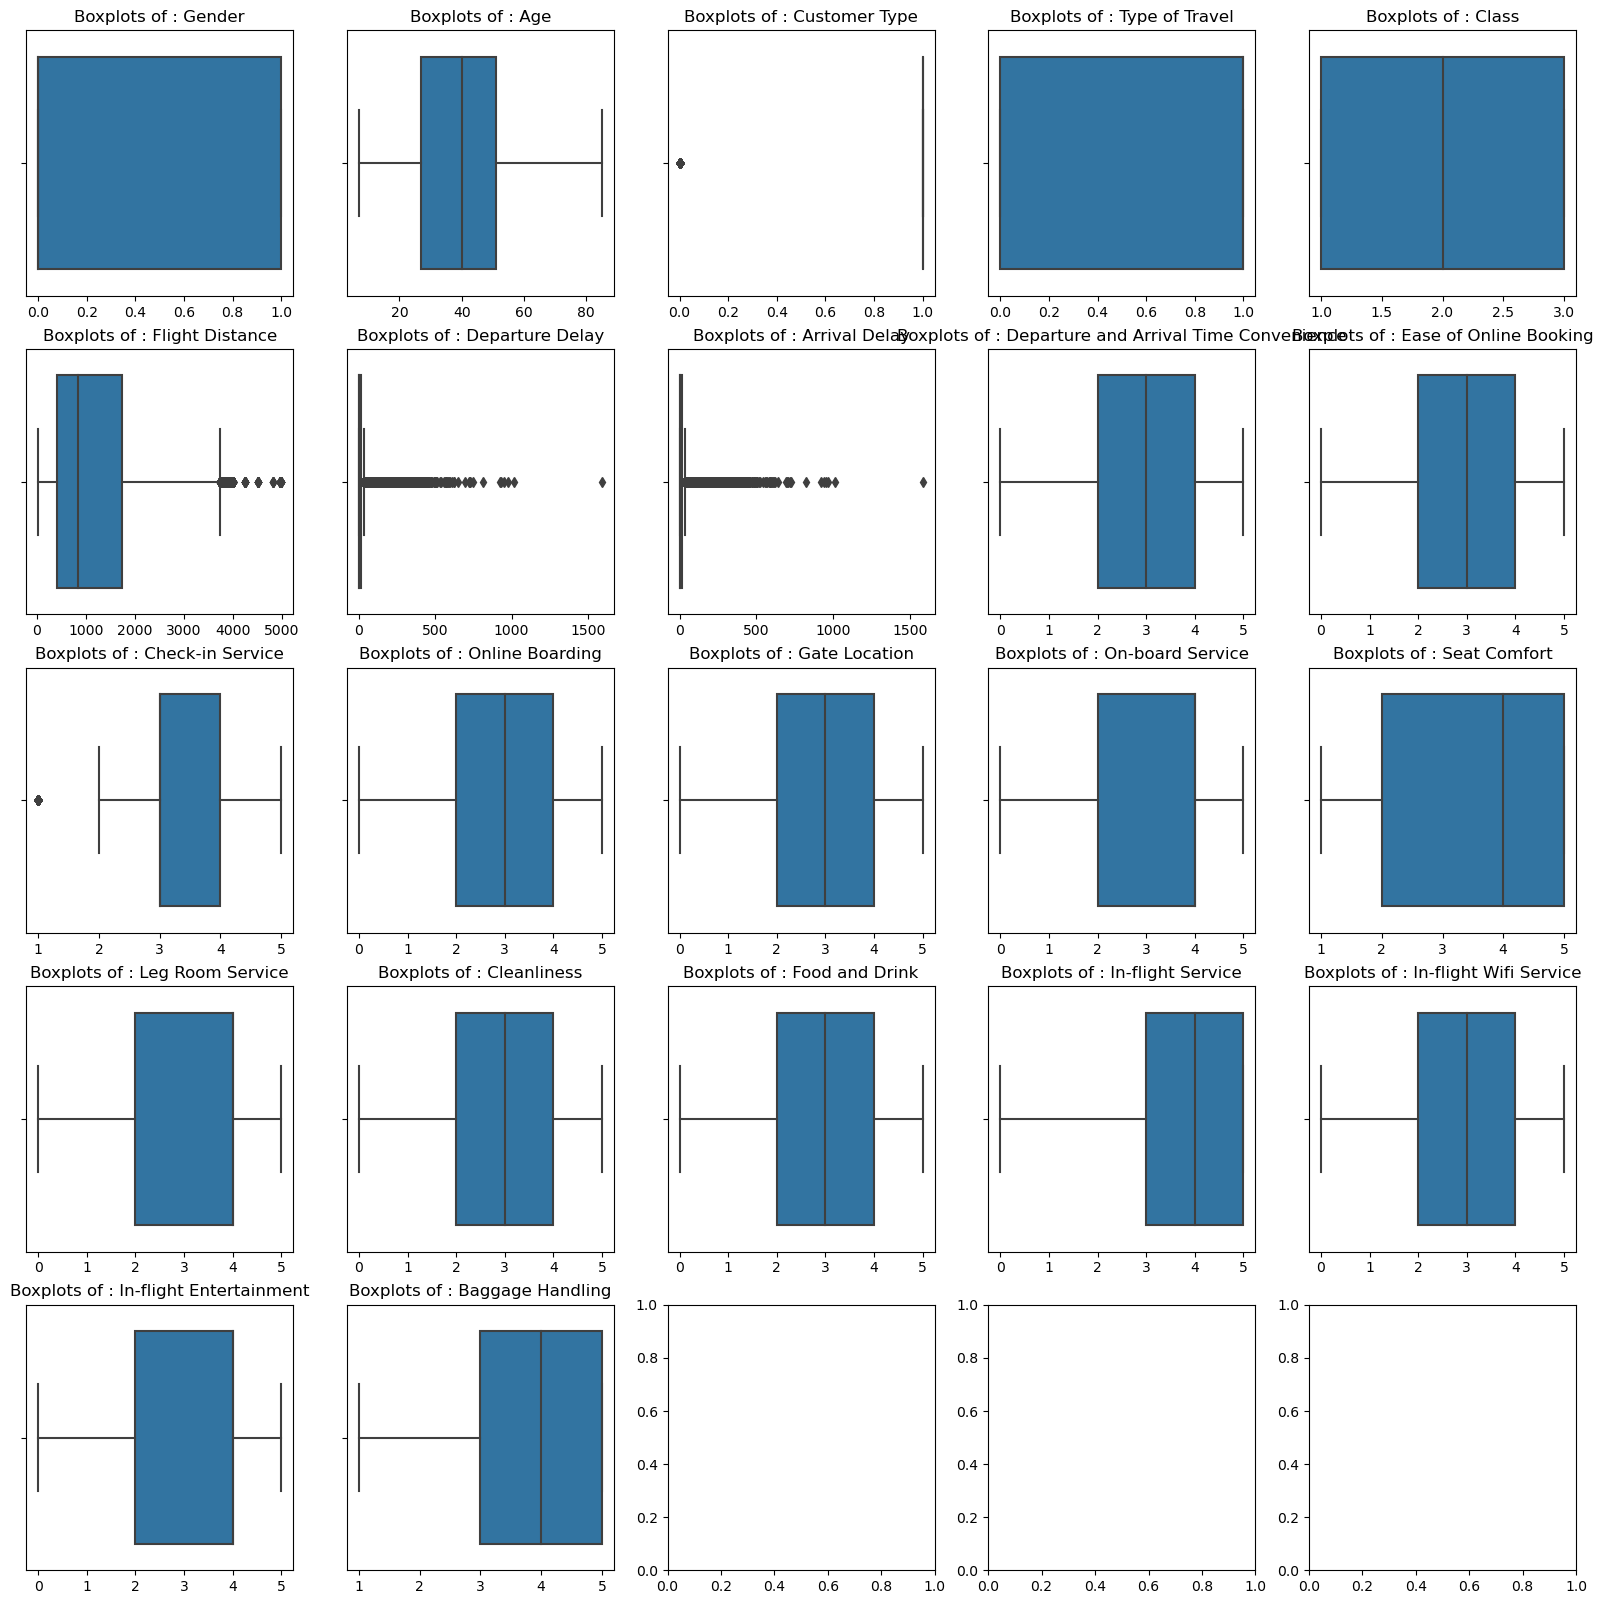

In [26]:
#Boxplots for all regressands
fig, axes = plt.subplots(ncols=5, nrows=5, figsize=(20, 20))
for i, ax in zip(x_train_full.columns, axes.flat):
    sns.boxplot(x=x_train_full[i], ax=ax).set(title=f"Boxplots of : {i}", xlabel="")
plt.show() 

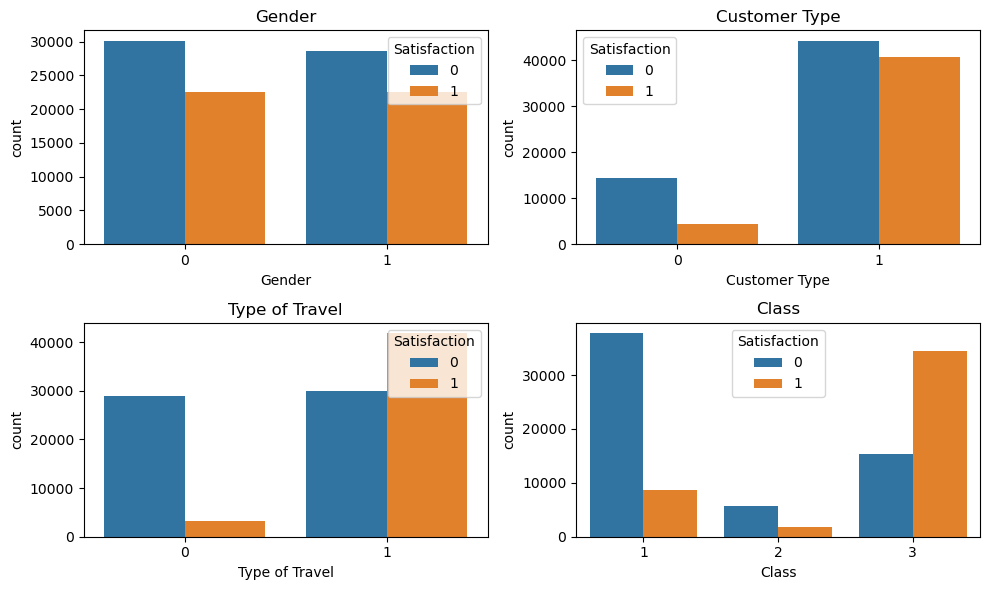

In [27]:
#Certain categorical variables regarding target distinction
my_data= ['Gender', 'Customer Type','Type of Travel','Class']
plt.figure(figsize=(10,6))
for i in range(len(my_data)):
    plt.subplot(2,2,i+1)
    plt.title(my_data[i])
    sns.countplot(x=x_train_full[my_data[i]],hue=y_train_full.Satisfaction)    
plt.tight_layout() 

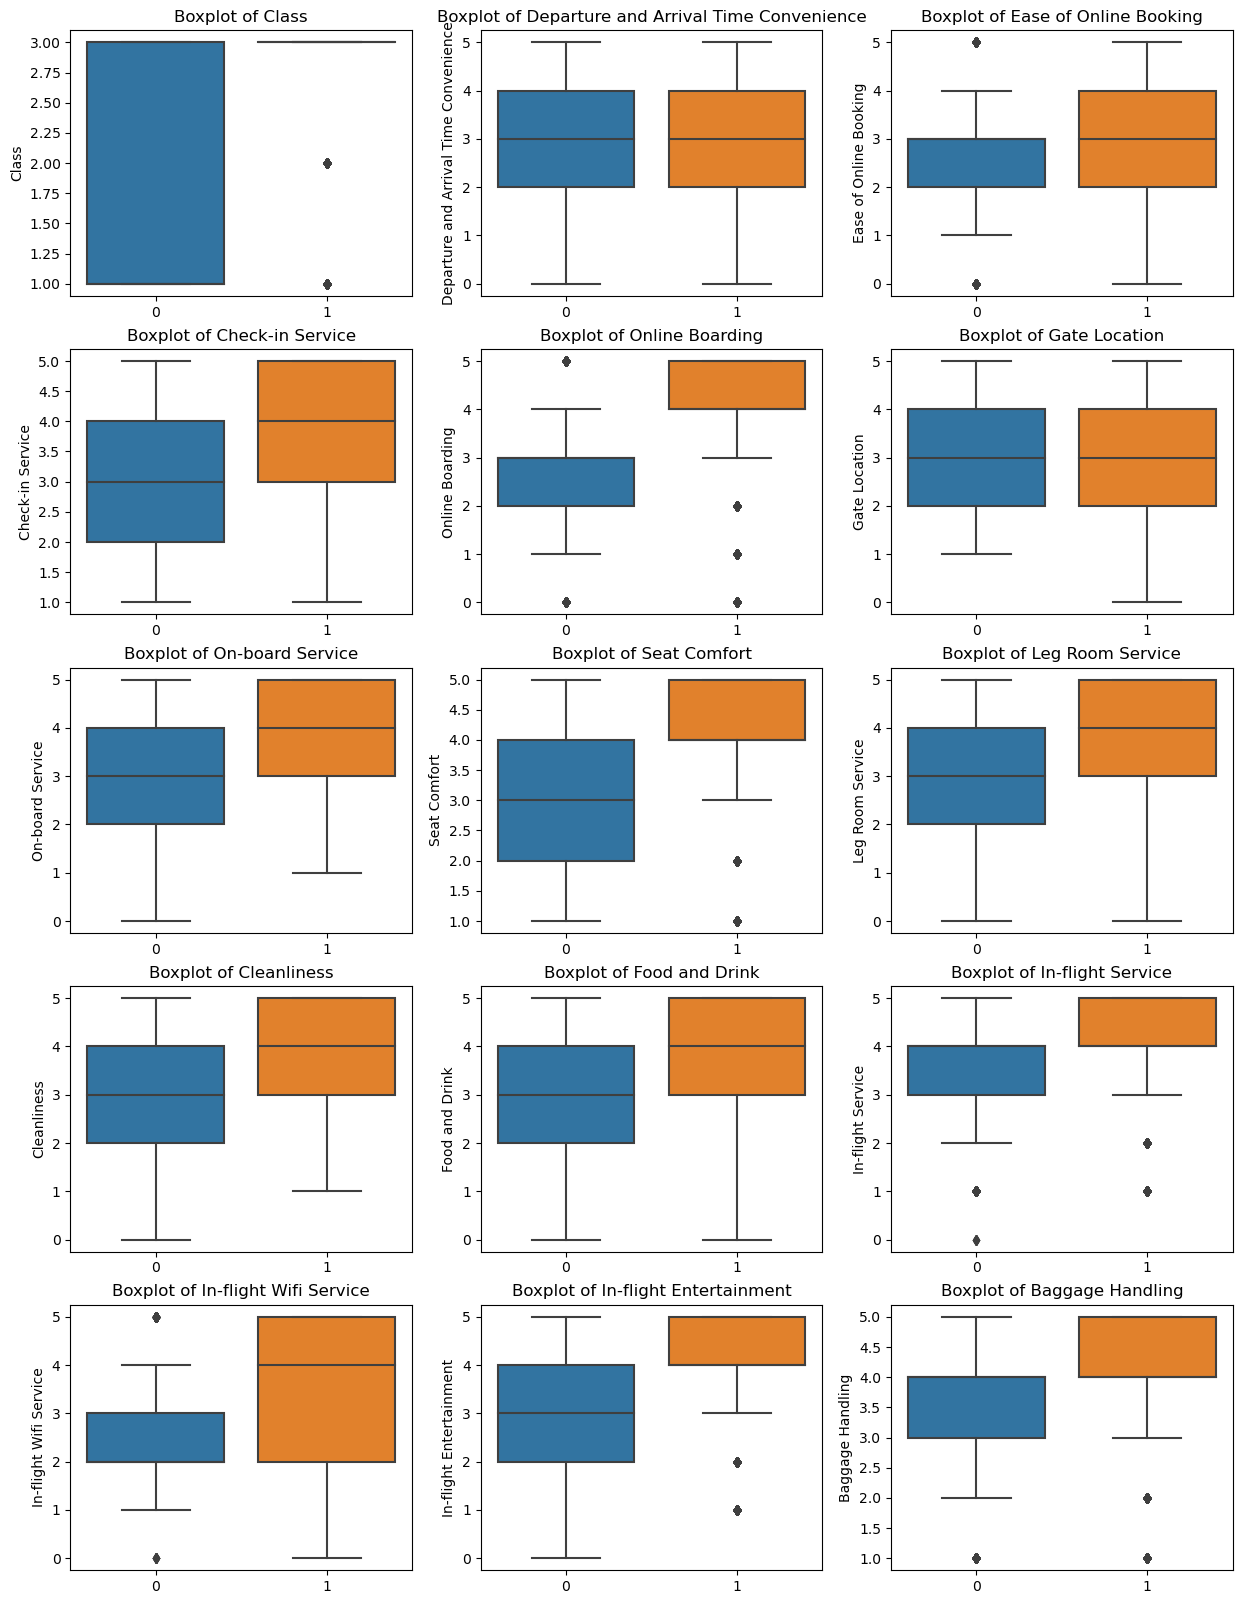

In [28]:
#Boxplots for rest of catecorical variables with division by target
categorical= ['Class', 'Departure and Arrival Time Convenience', 'Ease of Online Booking','Check-in Service','Online Boarding', 'Gate Location', 'On-board Service', 'Seat Comfort', 'Leg Room Service', 'Cleanliness', 'Food and Drink', 'In-flight Service', 'In-flight Wifi Service', 'In-flight Entertainment', 'Baggage Handling']
fig, axes = plt.subplots(ncols=3, nrows=5, figsize=(15, 20))
for i, ax in zip(categorical, axes.flat):
    sns.boxplot(x=y_train_full.Satisfaction, y=x_train_full[i], ax=ax).set(title=f"Boxplot of {i}", xlabel="")
plt.show()

<Axes: xlabel='Gender', ylabel='Age'>

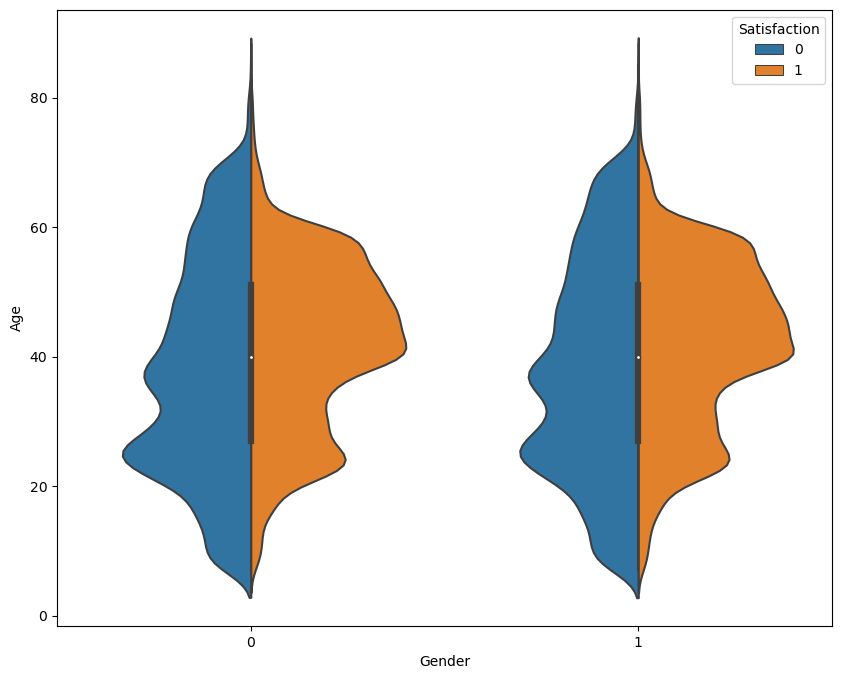

In [29]:
#Violin plot for "Age"
fig = plt.figure(figsize=(10,8))
sns.violinplot(x=x_train_full['Gender'], y=x_train_full['Age'], hue=y_train_full.Satisfaction,split=True) 

C:\Users\mbuda\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:5283: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


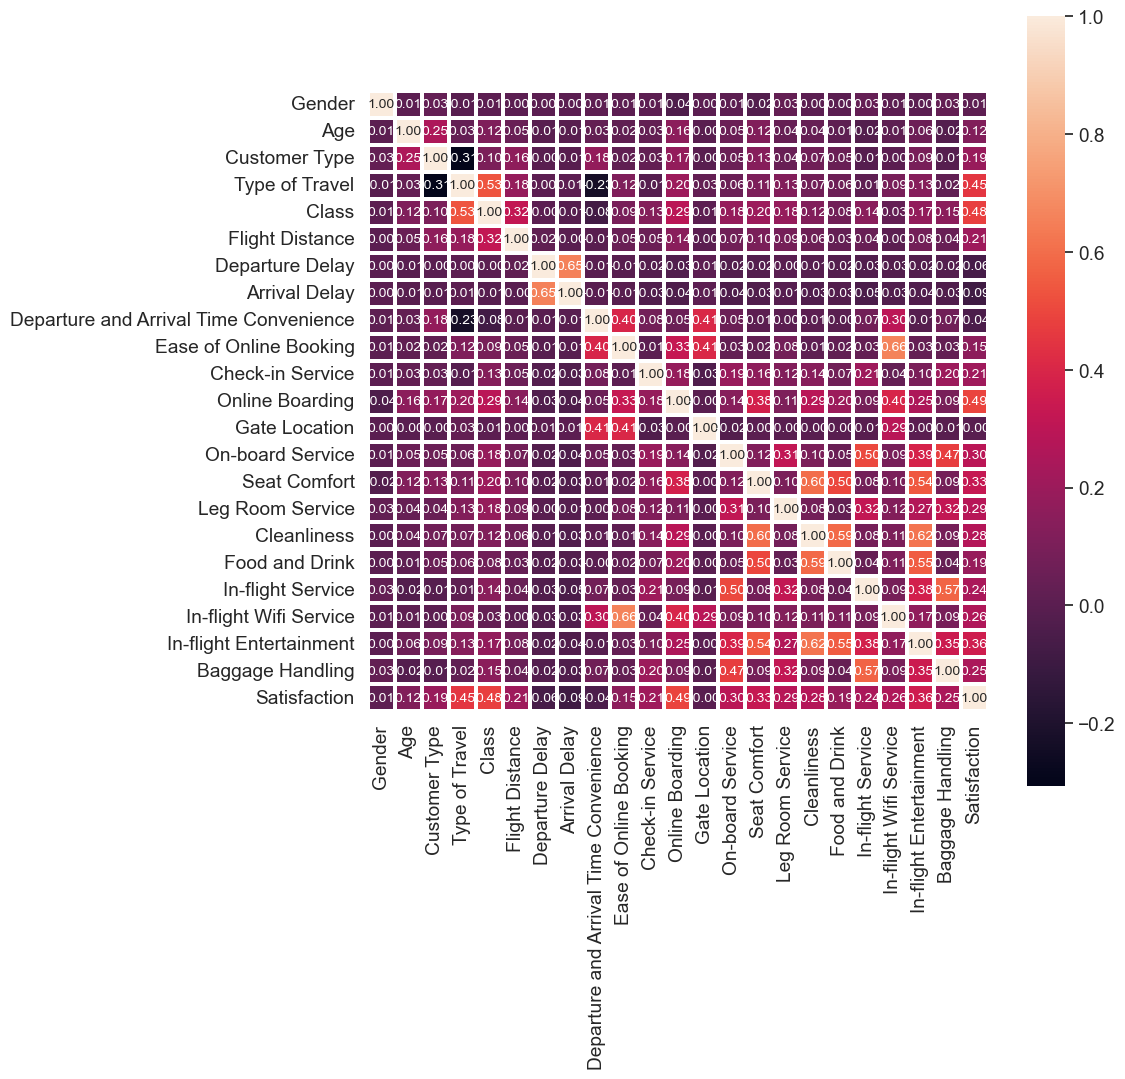

In [30]:
#Heatmap presenting correlation between features
corr = df_train.corr(method="kendall")
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(
    corr, linewidths=1.5, annot=True, square=True, fmt=".2f", annot_kws={"size": 10}
)
plt.show()

<Axes: >

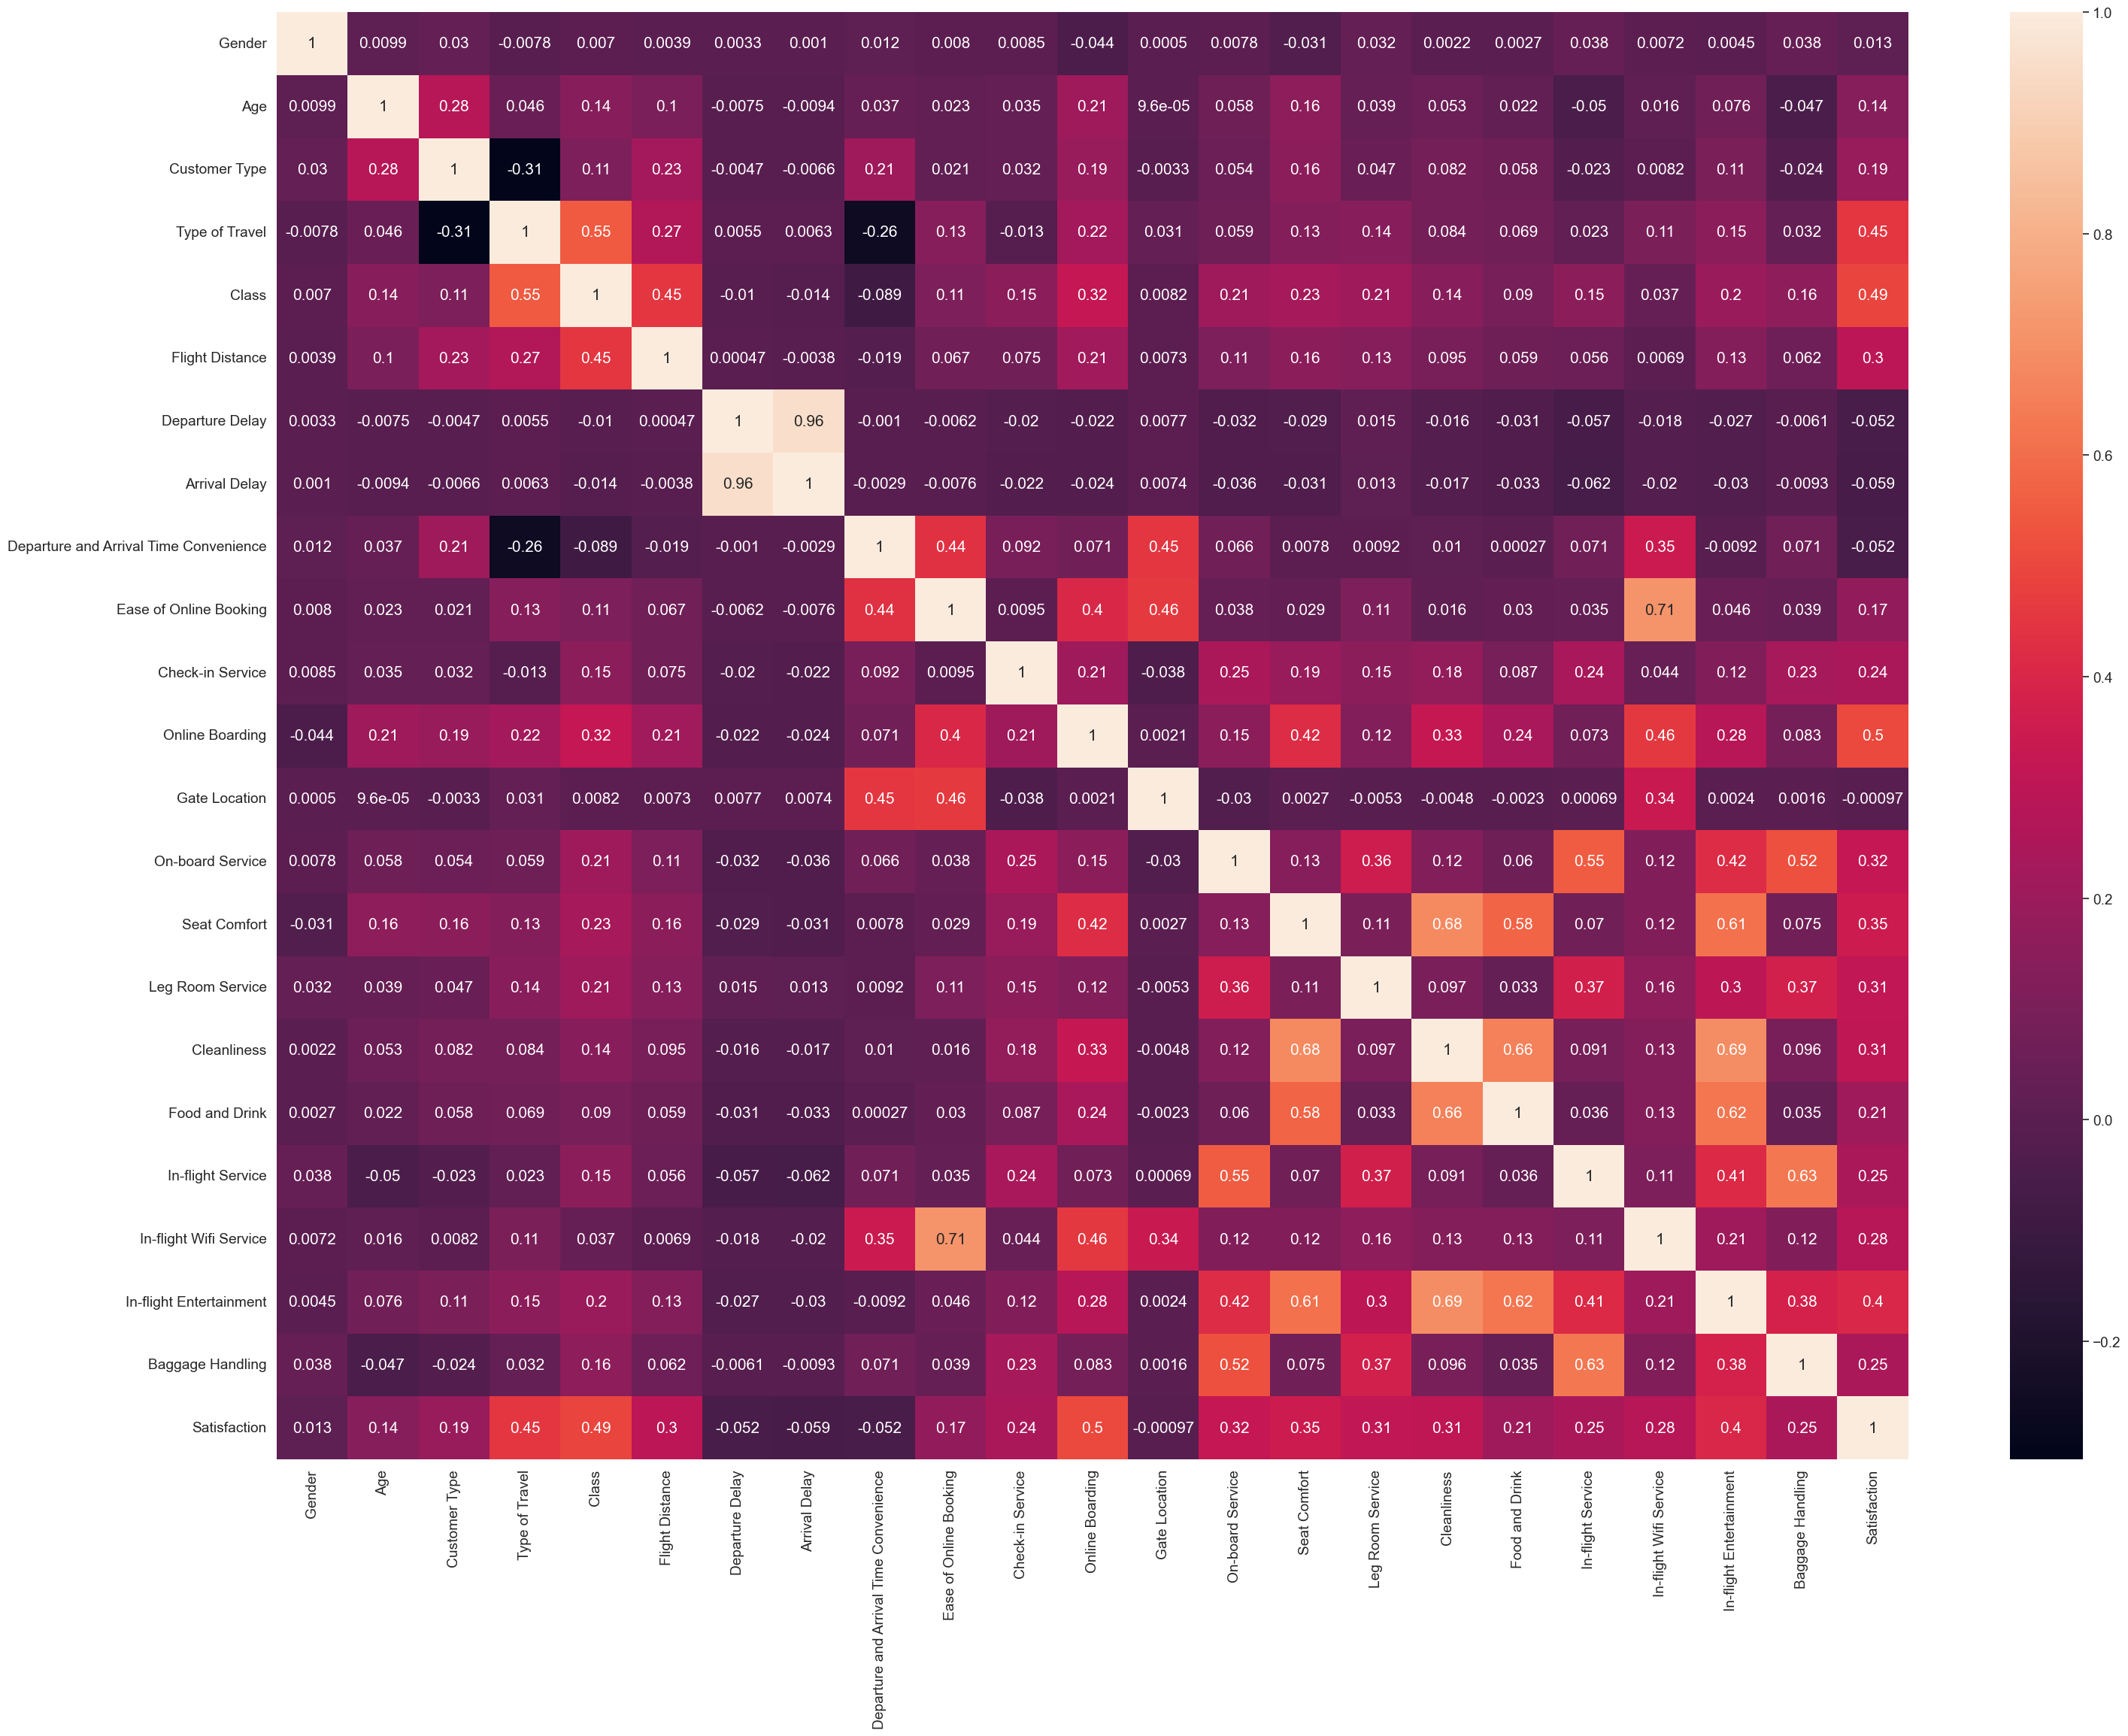

In [31]:
#Alternative way to present it
plt.figure(figsize=(35,25))
sns.heatmap(df_train.corr(), annot=True)

STATISTICAL ANALYSIS

In [32]:
#For instance, let's perform Univariate analysis of "Age" variable
sc.kurtosis(x_train_full.Age, axis=0, fisher=True, keepdims=False)

-0.7147433335754485

In [33]:
sc.skew(x_train_full.Age, axis=0, keepdims=False)

-0.004671954480928973

(5.375, 86.625)

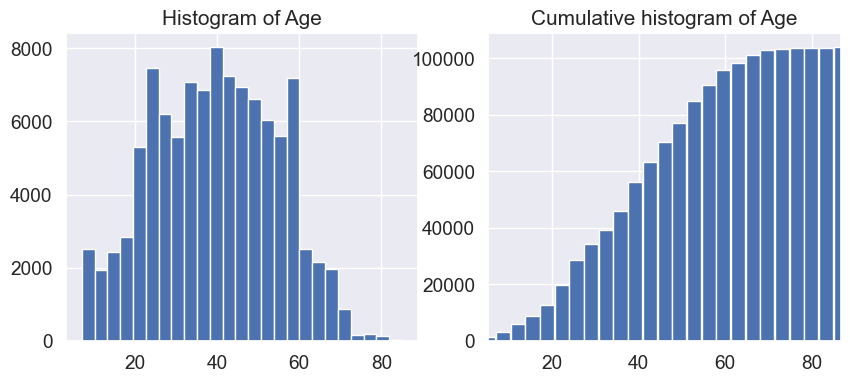

In [34]:
res = sc.cumfreq(x_train_full.Age, numbins=25)
fig = plt.figure(figsize=(10, 4))
x = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size,
                                 res.cumcount.size)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.hist(x_train_full.Age, bins=25)
ax1.set_title('Histogram of Age')
ax2.bar(x, res.cumcount, width=res.binsize)
ax2.set_title('Cumulative histogram of Age')
ax2.set_xlim([x.min(), x.max()])

In [35]:
#One-way ANOVA- H0: same mean "Age" between "Satisfaction" groups
sc.f_oneway(y_train_full.Satisfaction, x_train_full.Age, axis=0) #we reject H0: different means within groups

F_onewayResult(statistic=691535.7390457828, pvalue=0.0)

In [36]:
#Let's see whether "Age" has normal distribution
sc.normaltest(x_train_full.Age, axis=0) # no it doesn't

NormaltestResult(statistic=5893.9081056912855, pvalue=0.0)

In [37]:
#Non-parametrical one-way ANOVA (which is better due to lack of normal distribution assumption)
sc.kruskal(y_train_full.Satisfaction, x_train_full.Age, axis=0) #still we reject H0: different means within groups

KruskalResult(statistic=161160.83701202134, pvalue=0.0)

In [38]:
#Chi-square test
sc.chisquare(x_train_full.Age, axis=0) #we reject H0: data has same frequencies in particular groups

Power_divergenceResult(statistic=601625.6219404949, pvalue=0.0)

In [39]:
# Performing two-way ANOVA 
model = smf.ols('y_train_full.Satisfaction ~ Class+Age+Gender', 
            data=x_train_full).fit() 
result = sm.stats.anova_lm(model, type=2) 
  
# Print the result 
print(result)  #H1: there is a difference in mean for each variable regarding "Satisfaction" variable

                df        sum_sq      mean_sq             F         PR(>F)
Class          1.0   6183.429933  6183.429933  33416.544881   0.000000e+00
Age            1.0    114.980695   114.980695    621.379653  9.481152e-137
Gender         1.0      1.818522     1.818522      9.827671   1.719537e-03
Residual  103900.0  19225.756953     0.185041           NaN            NaN


FEATURE ENGINEERING

Firstly, let's clip the "Arrival Delay" and "Departure Delay" variables

In [40]:
x_train["Arrival Delay"].describe() 

count    83123.000000
mean        15.084333
std         38.261260
min          0.000000
25%          0.000000
50%          0.000000
75%         13.000000
max       1584.000000
Name: Arrival Delay, dtype: float64

In [41]:
#Let's look at some upper centiles
{i: x_train["Arrival Delay"].quantile(i) for i in np.arange(0.9, 1.01, 0.01)} #huge outliers after 0.99 centile

{0.9: 44.0,
 0.91: 49.0,
 0.92: 54.0,
 0.93: 60.0,
 0.9400000000000001: 68.0,
 0.9500000000000001: 78.0,
 0.9600000000000001: 91.0,
 0.9700000000000001: 108.0,
 0.9800000000000001: 135.0,
 0.9900000000000001: 183.0,
 1.0: 1584.0}

In [42]:
#Will the 0.99 quantile be reasonable?
x_train[x_train['Arrival Delay']>=x_train['Arrival Delay'].quantile(0.99)].shape #small proportion of dataset

(836, 22)

In [43]:
cutoff_arr_delay = x_train['Arrival Delay'].quantile(0.99)
x_train['Arrival Delay Cut']=x_train['Arrival Delay'].clip(upper=cutoff_arr_delay)

<Axes: >

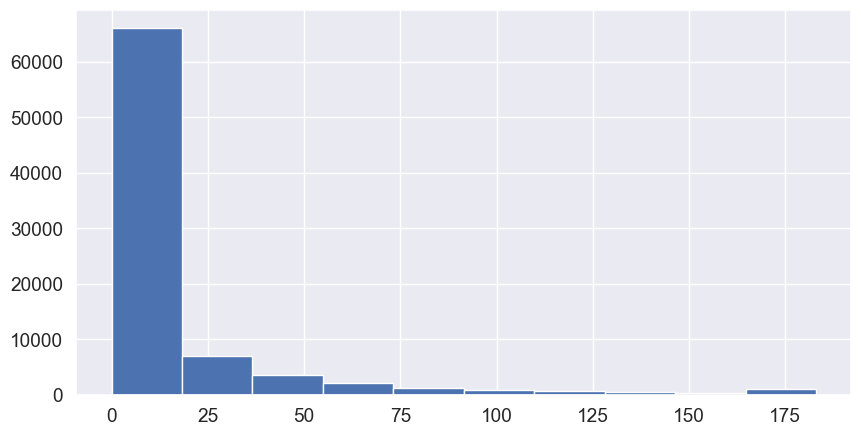

In [44]:
x_train['Arrival Delay Cut'].hist(figsize=(10, 5), bins=10) #still strong assymetry of data

<Axes: >

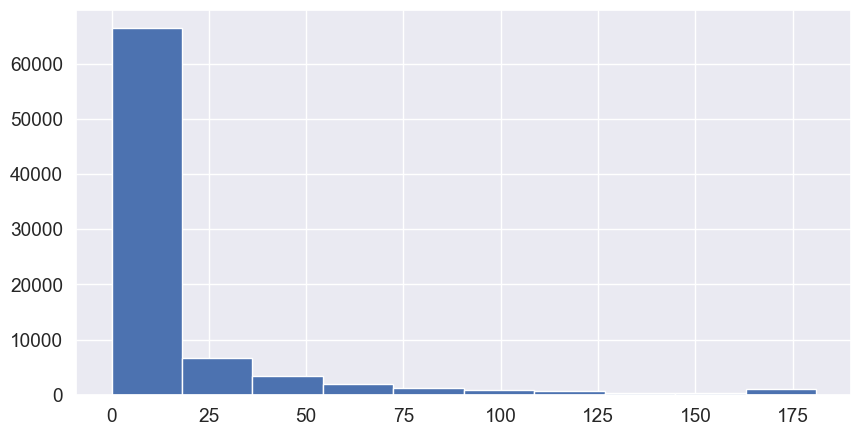

In [45]:
#Same transformation to 'Deprature delay'
cutoff_dep_delay = x_train['Departure Delay'].quantile(0.99)
x_train['Departure Delay Cut']=x_train['Departure Delay'].clip(upper=cutoff_dep_delay)
x_train['Departure Delay Cut'].hist(figsize=(10, 5), bins=10) #still strong assymetry of data

Nextly, let's look at 'Flight distance'

C:\Users\mbuda\AppData\Local\Temp\ipykernel_29140\2420972630.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x_train.iloc[:,5], color="olive")


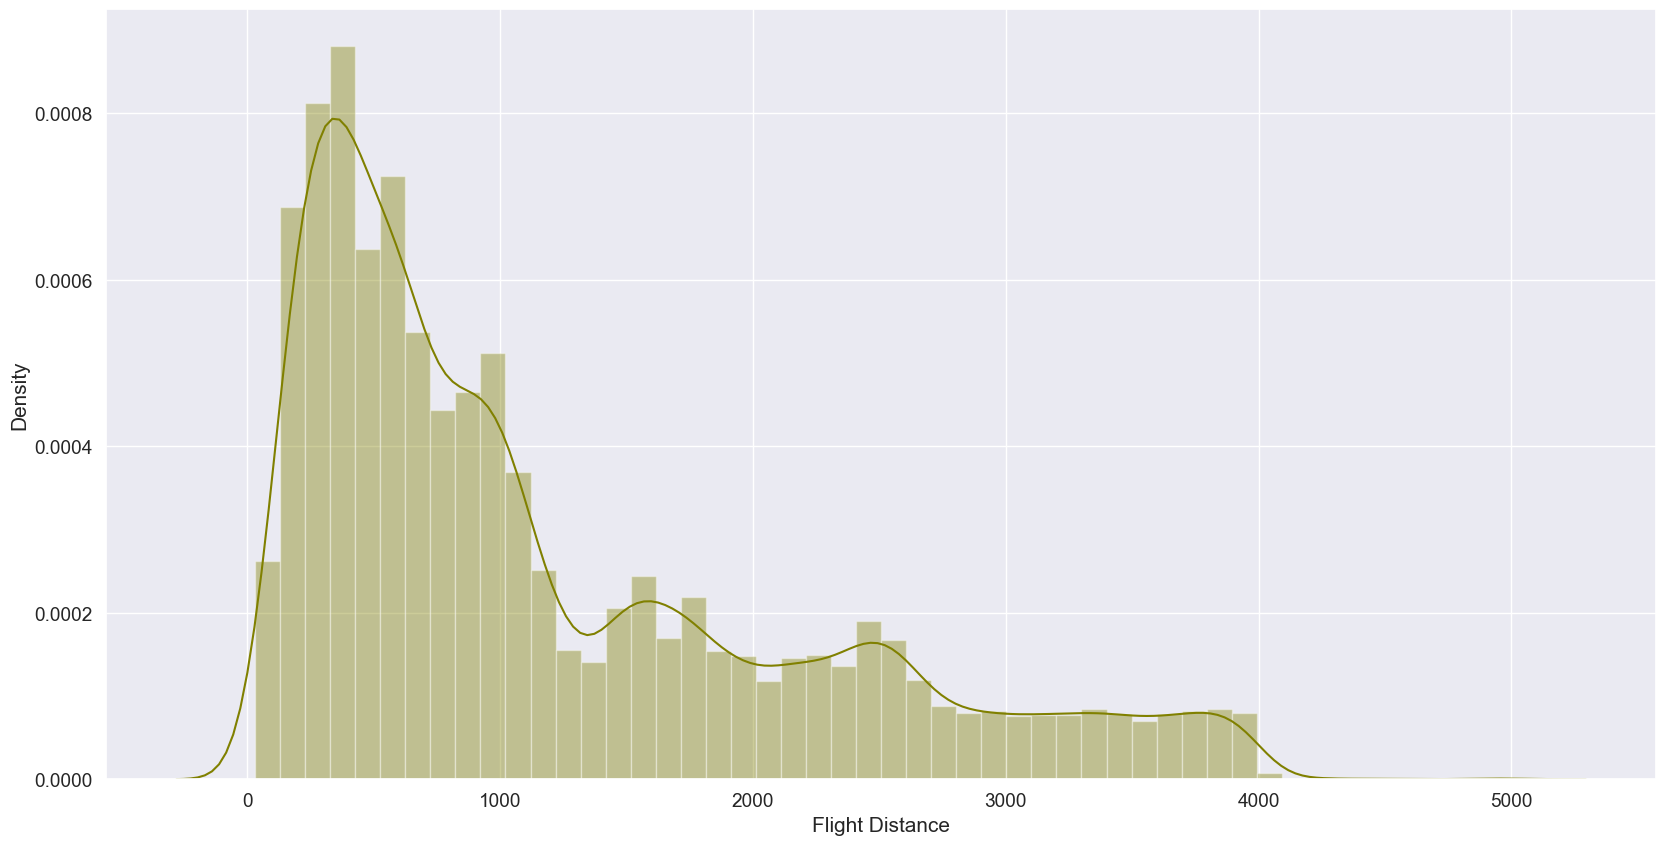

In [46]:
plt.subplots(figsize=(20,10), sharex=False)
sns.distplot(x_train.iloc[:,5], color="olive")
plt.show()

In [47]:
x_train["Flight Distance"].describe() #Due to high absolute value a logarithmic transformation is desirable

count    83123.000000
mean      1188.217701
std        997.092169
min         31.000000
25%        413.000000
50%        838.000000
75%       1741.000000
max       4983.000000
Name: Flight Distance, dtype: float64

<Axes: >

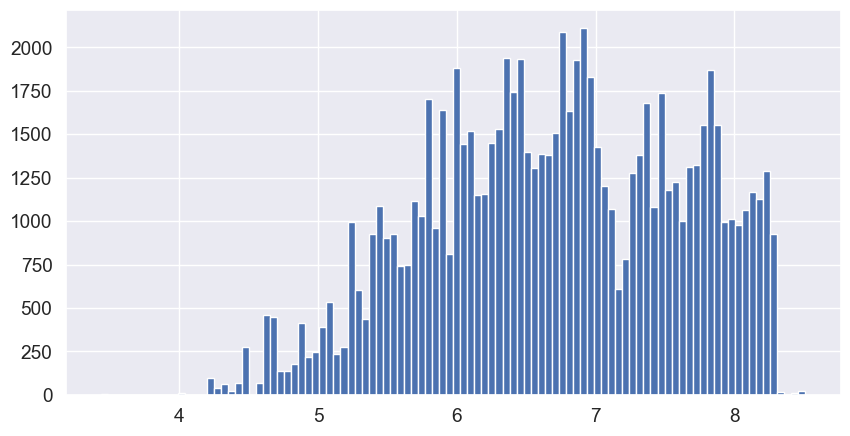

In [48]:
np.log(x_train["Flight Distance"]).hist(figsize=(10, 5), bins=100) #seems reasonable

In [49]:
x_train["Flight Distance Log"]=np.log(x_train["Flight Distance"])

Now, let's standardize the 'Age' variable

C:\Users\mbuda\AppData\Local\Temp\ipykernel_29140\1262797404.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x_train.iloc[:,1], color="skyblue")


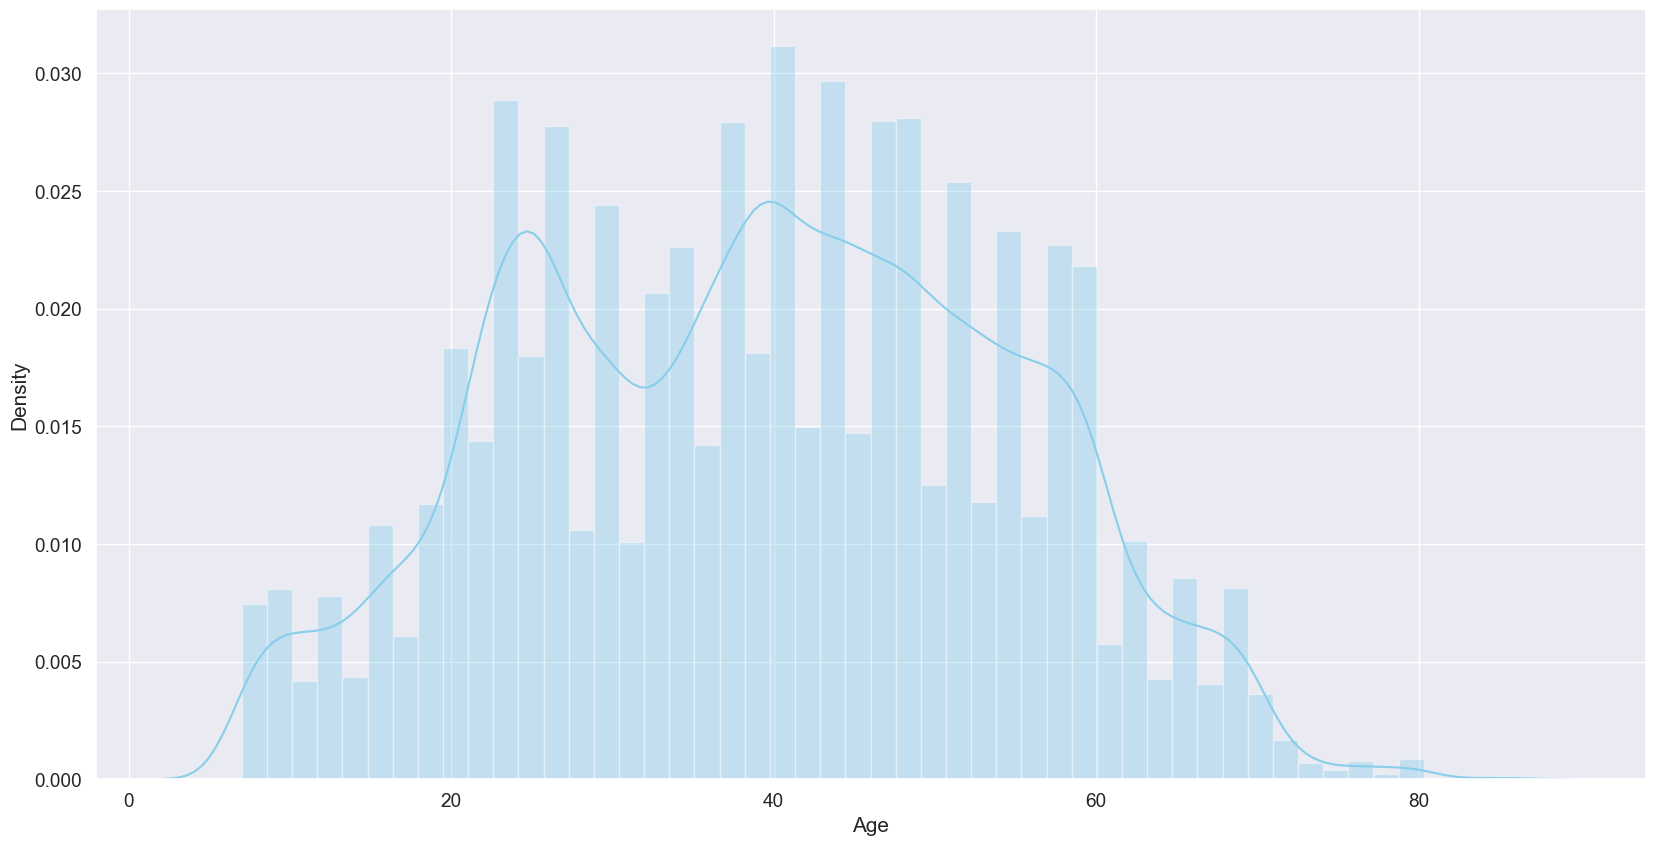

In [50]:
plt.subplots(figsize=(20,10), sharex=False)
sns.distplot(x_train.iloc[:,1], color="skyblue")
plt.show() #Gaussian-like shape of plot

In [51]:
scaler = StandardScaler()
scaler.fit(x_train["Age"].values.reshape(-1,1))

StandardScaler()

In [52]:
scaler.mean_

array([39.39779604])

In [53]:
x_train["Age"].mean()

39.397796037197885

<Axes: >

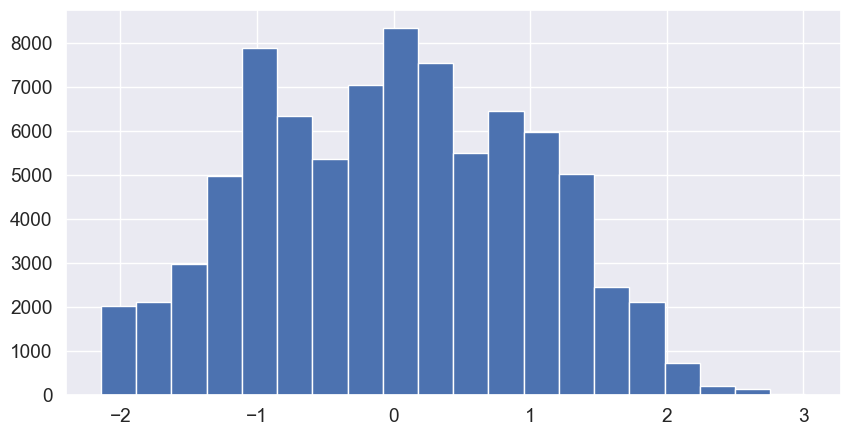

In [54]:
x_train["Age ZScore"] = scaler.transform(x_train["Age"].values.reshape(-1,1))
x_train["Age ZScore"].hist(figsize=(10, 5), bins=20)

Let's drop the "initial" variables that were transformed

In [55]:
x_train = x_train.drop(columns=["Age"])
x_train = x_train.drop(columns=["Flight Distance"])
x_train = x_train.drop(columns=["Departure Delay"])
x_train = x_train.drop(columns=["Arrival Delay"])

In [56]:
x_train.describe()

,Gender,Customer Type,Type of Travel,Class,Departure and Arrival Time Convenience,Ease of Online Booking,Check-in Service,Online Boarding,Gate Location,On-board Service,...,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Arrival Delay Cut,Departure Delay Cut,Flight Distance Log,Age ZScore
count,83123.000000,83123.000000,83123.000000,83123.000000,83123.000000,83123.000000,83123.000000,83123.000000,83123.000000,83123.000000,...,83123.000000,83123.000000,83123.000000,83123.000000,83123.000000,83123.000000,83123.000000,83123.000000,83123.000000,8.312300e+04
mean,0.491849,0.816308,0.692612,2.031592,3.055267,2.757287,3.305150,3.251928,2.975639,3.383336,...,3.286672,3.202555,3.636912,2.727320,3.355064,3.629826,14.220877,13.888178,6.702649,1.480529e-16
std,0.499937,0.387235,0.461414,0.962277,1.526859,1.403661,1.266288,1.350247,1.279617,1.286975,...,1.314118,1.329946,1.178457,1.329887,1.334786,1.182987,31.321949,30.967683,0.916797,1.000006e+00
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3.433987,-2.142095e+00
25%,0.000000,1.000000,0.000000,1.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,3.000000,2.000000,2.000000,3.000000,0.000000,0.000000,6.023448,-8.197241e-01
50%,0.000000,1.000000,1.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,...,3.000000,3.000000,4.000000,3.000000,4.000000,4.000000,0.000000,0.000000,6.731018,3.981684e-02
75%,1.000000,1.000000,1.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,5.000000,4.000000,4.000000,5.000000,13.000000,12.000000,7.462215,7.671207e-01
max,1.000000,1.000000,1.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,183.000000,181.000000,8.513787,3.015151e+00


Final "polishing" of data

In [58]:
#Clearing of tags
def clear_names(pandas_cols):
    return (
        pandas_cols.str.replace(" ", "_")
        .str.replace("(", "")
        .str.replace(")", "")
        .str.replace("[", "")
        .str.replace("]", "")
        .str.replace(",", "")
        .str.replace("-", "_")
        .str.lower()
        .str.normalize("NFKD")
        .str.encode("ascii", errors="ignore")
        .str.decode("utf-8")
    )

In [59]:
x_train.columns = clear_names(x_train.columns)

In [60]:
#Downcast of dataframe
def downcast_dataframe(data):
    # Source: https://www.kaggle.com/anshuls235/time-series-forecasting-eda-fe-modelling
    df = data.copy()

    print("BEFORE downcast")
    print(df.info(memory_usage="deep"))
    print("=================")
    print("=================", "\n")

    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i, t in enumerate(types):
        # Integer
        if "int" in str(t):
            # Check if minimum and maximum are in the limit of int8
            if (
                df[cols[i]].min() > np.iinfo(np.int8).min
                and df[cols[i]].max() < np.iinfo(np.int8).max
            ):
                df[cols[i]] = df[cols[i]].astype(np.int8)
            # Check if minimum and maximum are in the limit of int16
            elif (
                df[cols[i]].min() > np.iinfo(np.int16).min
                and df[cols[i]].max() < np.iinfo(np.int16).max
            ):
                df[cols[i]] = df[cols[i]].astype(np.int16)
            # Check if minimum and maximum are in the limit of int32
            elif (
                df[cols[i]].min() > np.iinfo(np.int32).min
                and df[cols[i]].max() < np.iinfo(np.int32).max
            ):
                df[cols[i]] = df[cols[i]].astype(np.int32)
            # Choose int64
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        # Float
        elif "float" in str(t):
            if (
                df[cols[i]].min() > np.finfo(np.float32).min
                and df[cols[i]].max() < np.finfo(np.float32).max
            ):
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        # Object
        elif t == object:
            if cols[i] == "date":
                df[cols[i]] = pd.to_datetime(df[cols[i]], format="%Y-%m-%d")
            else:
                df[cols[i]] = df[cols[i]].astype("category")
    print("AFTER downcast")
    print(df.info(memory_usage="deep"))
    return df

In [61]:
x_train = downcast_dataframe(x_train) 

BEFORE downcast
<class 'pandas.core.frame.DataFrame'>
Int64Index: 83123 entries, 115462 to 49600
Data columns (total 22 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   gender                                  83123 non-null  int64  
 1   customer_type                           83123 non-null  int64  
 2   type_of_travel                          83123 non-null  int64  
 3   class                                   83123 non-null  int64  
 4   departure_and_arrival_time_convenience  83123 non-null  int64  
 5   ease_of_online_booking                  83123 non-null  int64  
 6   check_in_service                        83123 non-null  int64  
 7   online_boarding                         83123 non-null  int64  
 8   gate_location                           83123 non-null  int64  
 9   on_board_service                        83123 non-null  int64  
 10  seat_comfort                         

In [62]:
#Let's apply same trasformations to validation set and test set
x_test['Arrival Delay'].fillna(x_test['Arrival Delay'].median(), inplace=True)
cutoff_arr_delay = x_test['Arrival Delay'].quantile(0.99)
x_test['Arrival Delay Cut']=x_test['Arrival Delay'].clip(upper=cutoff_arr_delay)
cutoff_dep_delay = x_test['Departure Delay'].quantile(0.99)
x_test['Departure Delay Cut']=x_test['Departure Delay'].clip(upper=cutoff_dep_delay)
x_test["Flight Distance Log"]=np.log(x_test["Flight Distance"])
scaler = StandardScaler()
scaler.fit(x_test["Age"].values.reshape(-1,1))
x_test["Age ZScore"] = scaler.transform(x_test["Age"].values.reshape(-1,1))
x_test = x_test.drop(columns=["Age"])
x_test = x_test.drop(columns=["Flight Distance"])
x_test = x_test.drop(columns=["Departure Delay"])
x_test = x_test.drop(columns=["Arrival Delay"])
x_test.columns = clear_names(x_test.columns)
x_test = downcast_dataframe(x_test)

BEFORE downcast
<class 'pandas.core.frame.DataFrame'>
Int64Index: 25976 entries, 28551 to 33813
Data columns (total 22 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   gender                                  25976 non-null  int64  
 1   customer_type                           25976 non-null  int64  
 2   type_of_travel                          25976 non-null  int64  
 3   class                                   25976 non-null  int64  
 4   departure_and_arrival_time_convenience  25976 non-null  int64  
 5   ease_of_online_booking                  25976 non-null  int64  
 6   check_in_service                        25976 non-null  int64  
 7   online_boarding                         25976 non-null  int64  
 8   gate_location                           25976 non-null  int64  
 9   on_board_service                        25976 non-null  int64  
 10  seat_comfort                          

In [63]:
x_val['Arrival Delay'].fillna(x_val['Arrival Delay'].median(), inplace=True)
cutoff_arr_delay = x_val['Arrival Delay'].quantile(0.99)
x_val['Arrival Delay Cut']=x_val['Arrival Delay'].clip(upper=cutoff_arr_delay)
cutoff_dep_delay = x_val['Departure Delay'].quantile(0.99)
x_val['Departure Delay Cut']=x_val['Departure Delay'].clip(upper=cutoff_dep_delay)
x_val["Flight Distance Log"]=np.log(x_val["Flight Distance"])
scaler = StandardScaler()
scaler.fit(x_val["Age"].values.reshape(-1,1))
x_val["Age ZScore"] = scaler.transform(x_val["Age"].values.reshape(-1,1))
x_val = x_val.drop(columns=["Age"])
x_val = x_val.drop(columns=["Flight Distance"])
x_val = x_val.drop(columns=["Departure Delay"])
x_val = x_val.drop(columns=["Arrival Delay"])
x_val.columns = clear_names(x_val.columns)
x_val = downcast_dataframe(x_val)

BEFORE downcast
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20781 entries, 93778 to 115521
Data columns (total 22 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   gender                                  20781 non-null  int64  
 1   customer_type                           20781 non-null  int64  
 2   type_of_travel                          20781 non-null  int64  
 3   class                                   20781 non-null  int64  
 4   departure_and_arrival_time_convenience  20781 non-null  int64  
 5   ease_of_online_booking                  20781 non-null  int64  
 6   check_in_service                        20781 non-null  int64  
 7   online_boarding                         20781 non-null  int64  
 8   gate_location                           20781 non-null  int64  
 9   on_board_service                        20781 non-null  int64  
 10  seat_comfort                         

In [64]:
#Same procedure for artificial datasets that contain target variable
df_train['Arrival Delay'].fillna(df_train['Arrival Delay'].median(), inplace=True)
cutoff_arr_delay = df_train['Arrival Delay'].quantile(0.99)
df_train['Arrival Delay Cut']=df_train['Arrival Delay'].clip(upper=cutoff_arr_delay)
cutoff_dep_delay = df_train['Departure Delay'].quantile(0.99)
df_train['Departure Delay Cut']=df_train['Departure Delay'].clip(upper=cutoff_dep_delay)
df_train["Flight Distance Log"]=np.log(df_train["Flight Distance"])
scaler = StandardScaler()
scaler.fit(df_train["Age"].values.reshape(-1,1))
df_train["Age ZScore"] = scaler.transform(df_train["Age"].values.reshape(-1,1))
df_train = df_train.drop(columns=["Age"])
df_train = df_train.drop(columns=["Flight Distance"])
df_train = df_train.drop(columns=["Departure Delay"])
df_train = df_train.drop(columns=["Arrival Delay"])
df_train.columns = clear_names(df_train.columns)
df_train = downcast_dataframe(df_train)

BEFORE downcast
<class 'pandas.core.frame.DataFrame'>
Int64Index: 103904 entries, 74733 to 118270
Data columns (total 23 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   gender                                  103904 non-null  int64  
 1   customer_type                           103904 non-null  int64  
 2   type_of_travel                          103904 non-null  int64  
 3   class                                   103904 non-null  int64  
 4   departure_and_arrival_time_convenience  103904 non-null  int64  
 5   ease_of_online_booking                  103904 non-null  int64  
 6   check_in_service                        103904 non-null  int64  
 7   online_boarding                         103904 non-null  int64  
 8   gate_location                           103904 non-null  int64  
 9   on_board_service                        103904 non-null  int64  
 10  seat_comfort            

In [65]:
df_test['Arrival Delay'].fillna(df_test['Arrival Delay'].median(), inplace=True)
cutoff_arr_delay = df_test['Arrival Delay'].quantile(0.99)
df_test['Arrival Delay Cut']=df_test['Arrival Delay'].clip(upper=cutoff_arr_delay)
cutoff_dep_delay = df_test['Departure Delay'].quantile(0.99)
df_test['Departure Delay Cut']=df_test['Departure Delay'].clip(upper=cutoff_dep_delay)
df_test["Flight Distance Log"]=np.log(df_test["Flight Distance"])
scaler = StandardScaler()
scaler.fit(df_test["Age"].values.reshape(-1,1))
df_test["Age ZScore"] = scaler.transform(df_test["Age"].values.reshape(-1,1))
df_test = df_test.drop(columns=["Age"])
df_test = df_test.drop(columns=["Flight Distance"])
df_test = df_test.drop(columns=["Departure Delay"])
df_test = df_test.drop(columns=["Arrival Delay"])
df_test.columns = clear_names(df_test.columns)
df_test = downcast_dataframe(df_test)

BEFORE downcast
<class 'pandas.core.frame.DataFrame'>
Int64Index: 25976 entries, 28551 to 33813
Data columns (total 23 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   gender                                  25976 non-null  int64  
 1   customer_type                           25976 non-null  int64  
 2   type_of_travel                          25976 non-null  int64  
 3   class                                   25976 non-null  int64  
 4   departure_and_arrival_time_convenience  25976 non-null  int64  
 5   ease_of_online_booking                  25976 non-null  int64  
 6   check_in_service                        25976 non-null  int64  
 7   online_boarding                         25976 non-null  int64  
 8   gate_location                           25976 non-null  int64  
 9   on_board_service                        25976 non-null  int64  
 10  seat_comfort                          

In [66]:
#Sanity check
set(df_train.columns) - set(df_test.columns)

set()

In [67]:
set(x_train.columns) - set(x_test.columns)

set()